In [35]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import skew, kurtosis
from skimage.feature import graycomatrix, graycoprops,local_binary_pattern
from sklearn.metrics import accuracy_score
# from skimage.feature import daisy, hog, sift, surf


class_dict = {
    "aluminium_foil": (1, 216),
    "brown_bread": (2, 41),
    "corduroy": (3, 256),
    "cork": (4, 216),
    "cotton": (5, 257),
    "cracker": (6, 34),
    "linen": (7, 257),
    "orange_peel": (8, 25),
    "sponge": (9, 41),
    "styrofoam": (10, 41),
    "wool": (11, 216)
}

valid_class_split = [0, 216, 257, 513, 729, 986, 1020, 1277, 1302, 1343, 1384, 1600]

In [13]:
def load_images(mode):
    images = []
    labels = []
    training_path = ".\\data\\train" if mode == "train" else ".\\data\\valid"

    for label in tqdm(os.listdir(training_path), desc=f'Load {mode} data'):
        label_training_path = training_path + f"\\{label}"
        for image in os.listdir(label_training_path):
            image_label_training_path = label_training_path + f"\\{image}"
            img = cv2.imread(image_label_training_path)
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            images.append((img, img_gray))
            labels.append(class_dict[label][0])
    return images, labels

def assessment(y_valid, y_pred):
    acc = accuracy_score(y_valid, y_pred)
    print("Accuracy global: {:.2f}%".format(acc * 100))
    splitted = []
    for i in range(1, len(valid_class_split)):
        y_v = y_valid[valid_class_split[i-1]:valid_class_split[i]]
        y_p = y_pred[valid_class_split[i-1]:valid_class_split[i]]
        splitted.append((y_p, y_v))
        acc = accuracy_score(y_v, y_p)
        print(f"Accuracy {i}: {round(acc * 100,2)}%")
    return splitted

### Simple

In [25]:
def extract_features_1(mode):
    images, labels = load_images(mode)

    features = []
    for image_tuple in tqdm(images, desc=f"Extract {mode} features"):
        image = image_tuple[1]
        # Statistical features
        mean = np.mean(image)
        std = np.std(image)
        skewness = skew(image.flatten())
        kurtosis_ = kurtosis(image.flatten())

        features_ = [
            mean,
            std,
            skewness,
            kurtosis_,
        ]
        features.append(features_)
    features = np.array(features)
    labels = np.array(labels)

    return features, labels


X_train_1, y_train_1 = extract_features_1("train")
X_valid_1, y_valid_1 = extract_features_1("valid")

# Initialize the classifier
clf = RandomForestClassifier(random_state=42)

# Train the classifier on the training data
clf.fit(X_train_1, y_train_1)

# Predict the labels for the validation data
y_pred_1 = clf.predict(X_valid_1)

data_1 = assessment(y_valid_1, y_pred_1)

Extract valid features: 100%|██████████| 1600/1600 [00:15<00:00, 100.50it/s]


Accuracy global: 79.81%
Accuracy 1: 72.22%
Accuracy 2: 65.85%
Accuracy 3: 73.05%
Accuracy 4: 90.74%
Accuracy 5: 84.82%
Accuracy 6: 38.24%
Accuracy 7: 84.05%
Accuracy 8: 92.0%
Accuracy 9: 75.61%
Accuracy 10: 90.24%
Accuracy 11: 80.09%


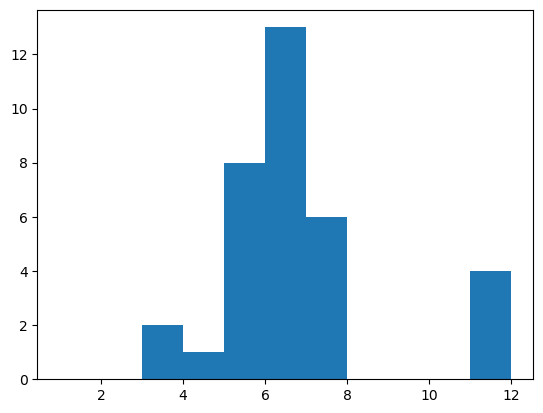

In [26]:
_ = plt.hist(data_1[5][0], bins=11, range=(1,12))
plt.show()

In [29]:
def extract_features_2(mode):
    images, labels = load_images(mode)

    features = []
    for image_tuple in tqdm(images, desc=f"Extract {mode} features"):
        image = image_tuple[1]
        # GLCM features
        glcm = graycomatrix(
            image,
            [5],
            [0],
            256,
            symmetric=True,
            normed=True,
        )
        contrast = graycoprops(glcm, "contrast").flatten()
        correlation = graycoprops(glcm, "correlation").flatten()
        energy = graycoprops(glcm, "energy").flatten()
        homogeneity = graycoprops(glcm, "homogeneity").flatten()
        dissimilarity = graycoprops(glcm, "dissimilarity").flatten()
        asm = graycoprops(glcm, "ASM").flatten()

        features_ = []
        features_.extend(contrast)
        features_.extend(correlation)
        features_.extend(energy)
        features_.extend(homogeneity)
        features_.extend(dissimilarity)
        features_.extend(asm)
        features.append(features_)
    features = np.array(features)
    labels = np.array(labels)

    return features, labels


X_train_2, y_train_2 = extract_features_2("train")
X_valid_2, y_valid_2 = extract_features_2("valid")

# Initialize the classifier
clf = RandomForestClassifier(random_state=42)

# Train the classifier on the training data
clf.fit(X_train_2, y_train_2)

# Predict the labels for the validation data
y_pred_2 = clf.predict(X_valid_2)

data_2 = assessment(y_valid_2, y_pred_2)

Extract valid features: 100%|██████████| 1600/1600 [00:07<00:00, 210.37it/s]


Accuracy global: 67.62%
Accuracy 1: 87.96%
Accuracy 2: 56.1%
Accuracy 3: 44.53%
Accuracy 4: 85.65%
Accuracy 5: 66.54%
Accuracy 6: 14.71%
Accuracy 7: 82.1%
Accuracy 8: 68.0%
Accuracy 9: 43.9%
Accuracy 10: 51.22%
Accuracy 11: 58.8%


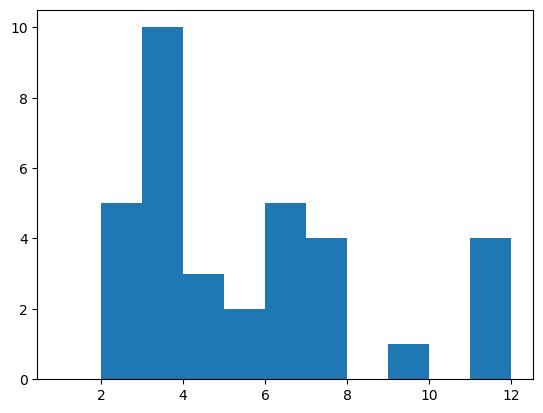

In [30]:
_ = plt.hist(data_2[5][0], bins=11, range=(1,12))
plt.show()

In [31]:
def extract_features_3(mode):
    images, labels = load_images(mode)

    features = []
    for image_tuple in tqdm(images, desc=f"Extract {mode} features"):
        image = image_tuple[1]
        # GLCM features
        glcm = graycomatrix(
            image,
            [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
            [0, np.pi/4, np.pi/2],
            256,
            symmetric=True,
            normed=True,
        )
        contrast = graycoprops(glcm, "contrast").flatten()
        correlation = graycoprops(glcm, "correlation").flatten()
        energy = graycoprops(glcm, "energy").flatten()
        homogeneity = graycoprops(glcm, "homogeneity").flatten()
        dissimilarity = graycoprops(glcm, "dissimilarity").flatten()
        asm = graycoprops(glcm, "ASM").flatten()

        features_ = []
        features_.extend(contrast)
        features_.extend(correlation)
        features_.extend(energy)
        features_.extend(homogeneity)
        features_.extend(dissimilarity)
        features_.extend(asm)
        features.append(features_)
    features = np.array(features)
    labels = np.array(labels)

    return features, labels


X_train_3, y_train_3 = extract_features_3("train")
X_valid_3, y_valid_3 = extract_features_3("valid")

# Initialize the classifier
clf = RandomForestClassifier(random_state=42)

# Train the classifier on the training data
clf.fit(X_train_3, y_train_3)

# Predict the labels for the validation data
y_pred_3 = clf.predict(X_valid_3)

data_3 = assessment(y_valid_3, y_pred_3)

Extract valid features: 100%|██████████| 1600/1600 [07:10<00:00,  3.71it/s]


Accuracy global: 88.00%
Accuracy 1: 95.83%
Accuracy 2: 78.05%
Accuracy 3: 88.28%
Accuracy 4: 89.81%
Accuracy 5: 86.38%
Accuracy 6: 67.65%
Accuracy 7: 86.38%
Accuracy 8: 96.0%
Accuracy 9: 65.85%
Accuracy 10: 75.61%
Accuracy 11: 92.59%


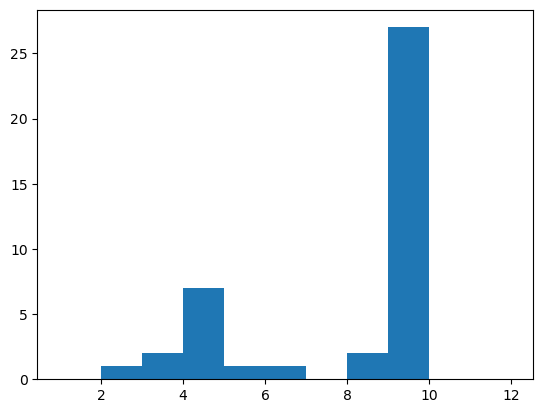

In [32]:
_ = plt.hist(data_3[8][0], bins=11, range=(1,12))
plt.show()

In [36]:
def extract_features_4(mode):
    images, labels = load_images(mode)

    features = []
    for image_tuple in tqdm(images, desc=f"Extract {mode} features"):
        image = image_tuple[1]
        # LBP features
        radius = 5
        n_points = 8 * radius
        lbp = local_binary_pattern(image, n_points, radius)
        lbp = lbp.ravel()
        lbp_hist = np.histogram(
            lbp, density=True, bins=n_points + 2, range=(0, n_points + 2)
        )[0]

        features_ = []
        features_.extend(lbp_hist)
        features.append(features_)
    features = np.array(features)
    labels = np.array(labels)

    return features, labels


X_train_4, y_train_4 = extract_features_4("train")
X_valid_4, y_valid_4 = extract_features_4("valid")

# Initialize the classifier
clf = RandomForestClassifier(random_state=42)

# Train the classifier on the training data
clf.fit(X_train_4, y_train_4)

# Predict the labels for the validation data
y_pred_4 = clf.predict(X_valid_4)

data_4 = assessment(y_valid_4, y_pred_4)

Extract valid features: 100%|██████████| 1600/1600 [03:43<00:00,  7.15it/s]


Accuracy global: 66.69%
Accuracy 1: 87.04%
Accuracy 2: 19.51%
Accuracy 3: 66.02%
Accuracy 4: 77.31%
Accuracy 5: 69.65%
Accuracy 6: 35.29%
Accuracy 7: 70.43%
Accuracy 8: 4.0%
Accuracy 9: 29.27%
Accuracy 10: 78.05%
Accuracy 11: 54.63%


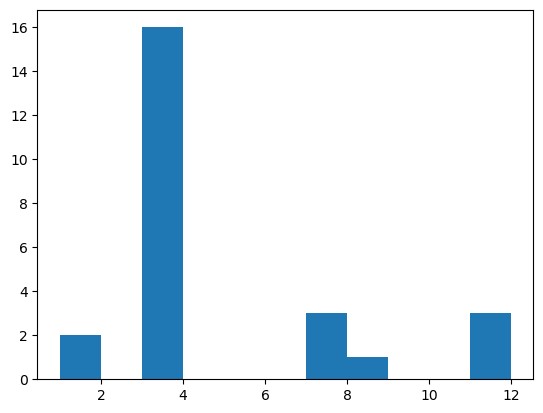

In [37]:
_ = plt.hist(data_4[7][0], bins=11, range=(1,12))
plt.show()

In [38]:
y_train = y_train_1
y_valid = y_valid_1

X_train_stat = X_train_1
X_valid_stat = X_valid_1

X_train_glcm = X_train_3
X_valid_glcm = X_valid_3

X_train_lbp = X_train_4
X_valid_lbp = X_valid_4

In [40]:
X_train_stat_glcm = np.concatenate((X_train_stat, X_train_glcm), axis=1)
X_valid_stat_glcm = np.concatenate((X_valid_stat, X_valid_glcm), axis=1)

X_train_stat_lbp = np.concatenate((X_train_stat, X_train_lbp), axis=1)
X_valid_stat_lbp = np.concatenate((X_valid_stat, X_valid_lbp), axis=1)

X_train_lbp_glcm = np.concatenate((X_train_lbp, X_train_glcm), axis=1)
X_valid_lbp_glcm = np.concatenate((X_valid_lbp, X_valid_glcm), axis=1)

X_train_stat_glcm_lbp = np.concatenate((X_train_stat_glcm, X_train_lbp), axis=1)
X_valid_stat_glcm_lbp = np.concatenate((X_valid_stat_glcm, X_valid_lbp), axis=1)

In [41]:
lf = RandomForestClassifier(random_state=42)

# Train the classifier on the training data
clf.fit(X_train_stat_glcm, y_train)

# Predict the labels for the validation data
y_pred_stat_glcm = clf.predict(X_valid_stat_glcm)

data_stat_glcm = assessment(y_valid, y_pred_stat_glcm)

Accuracy global: 90.50%
Accuracy 1: 93.98%
Accuracy 2: 82.93%
Accuracy 3: 91.41%
Accuracy 4: 94.91%
Accuracy 5: 90.66%
Accuracy 6: 79.41%
Accuracy 7: 87.94%
Accuracy 8: 96.0%
Accuracy 9: 63.41%
Accuracy 10: 82.93%
Accuracy 11: 93.52%


In [42]:
lf = RandomForestClassifier(random_state=42)

# Train the classifier on the training data
clf.fit(X_train_stat_lbp, y_train)

# Predict the labels for the validation data
y_pred_stat_lbp = clf.predict(X_valid_stat_lbp)

data_stat_lbp = assessment(y_valid, y_pred_stat_lbp)

Accuracy global: 83.62%
Accuracy 1: 94.91%
Accuracy 2: 53.66%
Accuracy 3: 77.73%
Accuracy 4: 95.83%
Accuracy 5: 83.27%
Accuracy 6: 26.47%
Accuracy 7: 84.44%
Accuracy 8: 88.0%
Accuracy 9: 56.1%
Accuracy 10: 90.24%
Accuracy 11: 84.72%


In [43]:
lf = RandomForestClassifier(random_state=42)

# Train the classifier on the training data
clf.fit(X_train_lbp_glcm, y_train)

# Predict the labels for the validation data
y_pred_lbp_glcm = clf.predict(X_valid_lbp_glcm)

data_lbp_glcm = assessment(y_valid, y_pred_lbp_glcm)

Accuracy global: 87.38%
Accuracy 1: 93.52%
Accuracy 2: 73.17%
Accuracy 3: 89.84%
Accuracy 4: 86.57%
Accuracy 5: 88.33%
Accuracy 6: 64.71%
Accuracy 7: 86.38%
Accuracy 8: 96.0%
Accuracy 9: 65.85%
Accuracy 10: 75.61%
Accuracy 11: 90.74%


In [44]:
lf = RandomForestClassifier(random_state=42)

# Train the classifier on the training data
clf.fit(X_train_stat_glcm_lbp, y_train)

# Predict the labels for the validation data
y_pred_stat_glcm_lbp = clf.predict(X_valid_stat_glcm_lbp)

data_stat_glcm_lbp = assessment(y_valid, y_pred_stat_glcm_lbp)

Accuracy global: 90.44%
Accuracy 1: 93.98%
Accuracy 2: 82.93%
Accuracy 3: 91.41%
Accuracy 4: 94.91%
Accuracy 5: 89.88%
Accuracy 6: 61.76%
Accuracy 7: 88.72%
Accuracy 8: 96.0%
Accuracy 9: 68.29%
Accuracy 10: 87.8%
Accuracy 11: 93.98%


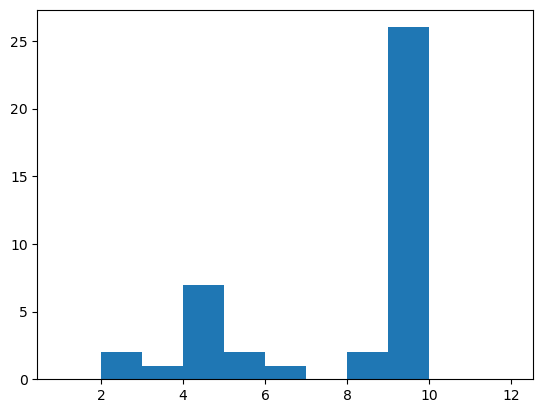

In [45]:
_ = plt.hist(data_stat_glcm[8][0], bins=11, range=(1,12))
plt.show()